<a href="https://colab.research.google.com/github/nllam717/face_detection_emotion/blob/master/TraindataEmotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   **Train dữ liệu fer2013 tổng 36000 ảnh, chia thành tập test và train**




In [4]:
!unzip '/content/drive/My Drive/dataEmotion.csv.zip'

Archive:  /content/drive/My Drive/dataEmotion.csv.zip
  inflating: fer2013.csv             


In [0]:
#thư viện dùng trong model
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
#thư viện xử lý data, array, matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#nạp data
filname = '/content/data.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('/content/data.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [0]:
# Hàm load dataset từ file CSV
def getData(filname):
    # tổng ảnh = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [8]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [0]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0) #test_size 0.3 tỉ lệ test 30% data
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [0]:
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

In [12]:
#model tự tạo theo các lớp conv2D để train ảnh theo size 48*48*1
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return model
model=my_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)      

In [13]:
path_model='model_filter2.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=50, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 25120 samples, validate on 10767 samples
Epoch 1/50
25120/25120 [==============================] - 22s 874us/step - loss: 1.7139 - accuracy: 0.3306 - val_loss: 1.5903 - val_accuracy: 0.3737
Epoch 2/50
25120/25120 [==============================] - 15s 583us/step - loss: 1.3918 - accuracy: 0.4688 - val_loss: 1.4625 - val_accuracy: 0.4552
Epoch 3/50
25120/25120 [==============================] - 15s 590us/step - loss: 1.1995 - accuracy: 0.5484 - val_loss: 1.4364 - val_accuracy: 0.4626
Epoch 4/50
25120/25120 [==============================] - 15s 592us/step - loss: 1.0648 - accuracy: 0.5996 - val_loss: 1.1723 - val_accuracy: 0.5617
Epoch 5/50
25120/25120 [==============================] - 15s 591us/step - loss: 0.9359 - accuracy: 0.6516 - val_loss: 1.1717 - val_accuracy: 0.5610
Epoch 6/50
25120/25120 [==============================] - 15s 590us/step - loss: 0.7794 - accuracy: 0.7129 - val_loss: 1.2194 - val_accuracy: 0.5756
Epoch 7/50
25120/25120 [==============================] 

In [27]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [0]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [0]:
from skimage import io
img = image.load_img('/content/5c0bce6c1df3e7adbee2.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('/content/5c0bce6c1df3e7adbee2.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

In [0]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# generate dataset

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [0]:
#overfitting
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve

import matplotlib as mpl
# Default parameters for matplotlib plots
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.facecolor'] = (0.9,0.9,0.9)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'w'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['legend.fontsize'] = 22
mpl.rcParams['legend.facecolor'] = [1,1,1]
mpl.rcParams['legend.framealpha'] = 0.75
mpl.rcParams['axes.labelsize'] = 22

In [0]:
clf_1 = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=0)
clf_1.fit(X_train, y_train)
# Number of folds for cross validation
num_folds = 7


### đang lỗi

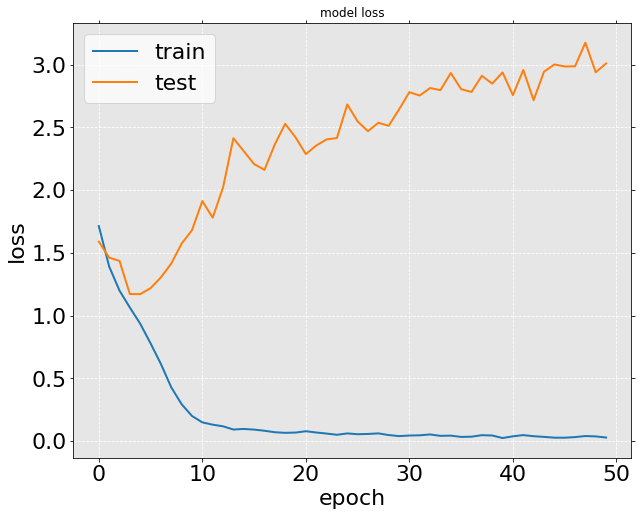

In [35]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,History
# now = datetime.now()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig("loss_{}.png".format(now))
plt.show()

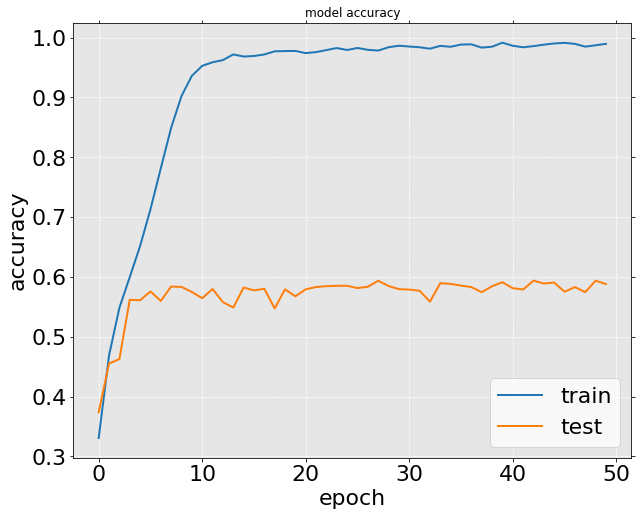

In [36]:
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig("accuracy_{}.png".format(now))
plt.show()